# Time Series Forecasting for Solar Energy Generation in Germany

## Table of Contents

* [1. Downloading data](#download)

* [2. Theory and functions for ARIMA models](#arima)
    * [2.0. Box-Jenkins method](#box)
    * [2.1. Identification](#identification)
        * [2.1.1. ADF test](#adf)
        * [2.1.2. ACF and PACF](#acf)
    * [2.2. Estimation](#estimation)
        * [2.2.1. AIC and BIC](#aic)
        * [2.2.2. PACF/ACF for different model](#pacf)
    * [2.3. Model diagnostics](#diagnostics)
    * [2.4. Seasonal differencing](#seasonal)
    * [2.5. Forecasting](#forecasting)
    * [2.6. Model accuracy](#accuracy)

* [3. Time Series Analysis for WEEKLY Solar Generation in Germany](#ts0)
    * [3.1. Identification](#identification_ts0)
    * [3.2. Estimation](#estimation_ts0)
    * [3.3. Model diagnostics](#diagnostics_ts0)
    * [3.4. Seasonal differencing](#seasonal_ts0)
    * [3.5. Forecasting](#forecasting_ts0)
    * [3.6. Model accuracy](#accuracy_ts0)

----



In [1]:
!pip install opendatasets


In [2]:
import sys
!{sys.executable} -m pip install missingno
import sys
!{sys.executable} -m pip install scikit-learn


In [3]:
import opendatasets as od
import re
import os

from datetime import datetime
from datetime import timezone
from datetime import date

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


In [4]:
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_percentage_error
import itertools

In [5]:
#0 Download Data

In [6]:
#Load daily generation
ger_daily_generation_df = pd.read_csv('all_ger_daily_generation.csv',sep='\t')
#Test and train data for model building
solar_train_df = pd.read_csv('train_ger_daily_generation.csv', sep='\t')
solar_test_df = pd.read_csv('test_ger_daily_generation.csv', sep='\t')

In [7]:
# weekly data
ger_daily_generation_df['cet_cest_timestamp'] = pd.to_datetime(ger_daily_generation_df['cet_cest_timestamp'], utc=True)
ger_daily_generation_df.set_index('cet_cest_timestamp', inplace=True)
ger_daily_generation_df.sort_index(inplace=True)
ger_weekly_generation_df = ger_daily_generation_df.resample('W').sum()


In [8]:
#Sliced data for model validation
slices = np.loadtxt('sliced_ger_daily_generation.txt', dtype=int)


In [9]:
#I Functions for Model Building

In [10]:
#Function to plot seasonal, trend and residual components of the data
def plot_seasonal_components(ts, period):
    
    decomp_weekly = seasonal_decompose(ts, period=period)

    fig, axes = plt.subplots(4, 1, sharex=True)

    decomp_weekly.observed.plot(ax=axes[0], legend=False, color='r', linewidth=1)
    axes[0].set_ylabel('Observed', fontsize=12)

    decomp_weekly.trend.plot(ax=axes[1], legend=False, color='g', linewidth=1)
    axes[1].set_ylabel('Trend', fontsize=12)

    decomp_weekly.seasonal.plot(ax=axes[2], legend=False, linewidth=1)
    axes[2].set_ylabel('Seasonal', fontsize=12)

    decomp_weekly.resid.plot(ax=axes[3], legend=False, color='k', linewidth=1)
    axes[3].set_ylabel('Residual', fontsize=12)
    
    return 1

In [11]:
# Function to check the stationarity of a time series using ADF and KPSS tests,
# iteratively applying differencing up to a specified maximum number of times.
# Returns a DataFrame summarizing the results of these tests for each differencing level.
def obtain_adf_kpss_results(ts, max_d):
    """ Build dataframe with ADF statistics and p-value for time series after applying difference on time series
    
    Args:
        ts (df): Dataframe of univariate time series  
        max_d (int): Max value of how many times apply difference
        
    Returns:
        Dataframe showing values of ADF statistics and p when applying ADF test after applying d times 
        differencing on a time-series.
    
    """
    
    results = []

    for idx in range(max_d):
        adf_result = adfuller(ts, autolag='AIC')
        kpss_result = kpss(ts, regression='c', nlags="auto")
        
        if adf_result[1] <= 0.05:
            adf_stationary = True
        else:
            adf_stationary = False
            
        if kpss_result[1] <= 0.05:
            kpss_stationary = False
        else:
            kpss_stationary = True
            
        stationary = adf_stationary & kpss_stationary
        results.append((idx, adf_result[1], kpss_result[1], adf_stationary, kpss_stationary, stationary))
        ts = ts.diff().dropna() # counter of differencing
    
    # Construct DataFrame 
    results_df = pd.DataFrame(results, columns=['d', 'adf_stats', 'p-value', 'is_adf_stationary', 'is_kpss_stationary', 'is_stationary' ])
    
    return results_df



In [12]:
#Box-Jenkins Methodology
#1. Identification
#2. Estimation
#3. Model Diagnostics

In [13]:
# 1 Identification

In [14]:
#1.1 ADF test
#ADF test for stationarity
def run_adf_test(ts, diff_order):
    '''
    diff_order = 0, 1, 2
    '''
    
    if diff_order == 0:
        ts0 = ts.dropna()
    elif diff_order == 1:
        ts0 = ts.dropna().diff().dropna()
    elif diff_order == 2:
        ts0 = ts.dropna().diff().dropna().diff().dropna()
    else:
        ts0 = ts.dropna()
        
    result = adfuller(ts0)
    
    fig, ax = plt.subplots()
    ts0.plot(ax=ax, linewidth=1)
    plt.show()

    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:', result[4])

    return 1

In [15]:
# 1.2 ACF and PACF
# Function to plot ACF and ACF plots
def plot_acf_pacf(ts, lags):

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))

#     for q
    plot_acf(ts.dropna(), lags=lags, zero=False, ax=ax1) # .diff().dropna()
#     for p
    plot_pacf(ts.dropna(), lags=lags, zero=False, ax=ax2) # .diff().dropna()

    plt.show()

    return 1

# def plot_acf_functions(ts, lags):
    
#     fig, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
#     plot_acf(ts.dropna(), lags=lags, ax=ax1)
#     plot_acf(ts.dropna().diff().dropna(), lags=lags, ax=ax2)
#     plot_acf(ts.dropna().diff().dropna().diff().dropna(), lags=lags, ax=ax3)
#     plt.show()

#     return 1

In [16]:
# 2 Estimation

In [17]:
#2.1 AIC and BIC
#Function to fit the model and sort the models by aic and bic values small to large
import concurrent.futures

def fit_arima(ts, p, d, q):
    try:
        model = ARIMA(ts, order=(p, d, q))
        results = model.fit()
        return (p, q, results.aic, results.bic)
    except Exception as e:
        return (p, q, None, None)

def sort_aic_bic(ts, d, max_p, max_q):
    # Prepare parameters for parallel processing
    params = [(ts, p, d, q) for p in range(max_p) for q in range(max_q)]
    
    # Use ThreadPoolExecutor to parallelize the ARIMA fitting
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda x: fit_arima(*x), params))
    
    # Create DataFrame from results
    order_df = pd.DataFrame(results, columns=['p', 'q', 'AIC', 'BIC'])
    
    # Sort by AIC and BIC once
    order_df_aic_sorted = order_df.sort_values('AIC').reset_index(drop=True)
    order_df_bic_sorted = order_df.sort_values('BIC').reset_index(drop=True)
    
    print("Sorting by AIC:")
    print(order_df_aic_sorted[:30])
    print()
    print("Sorting by BIC:")
    print(order_df_bic_sorted[:30])
    
    return 1


In [18]:
# 3 Model Diadnostics

In [19]:
# Function to fit an ARIMA model to a time series, calculate the mean absolute error of the residuals,
# print a summary of the model, and generate diagnostic plots to evaluate the model fit.
def arima_diagnostics(ts, p,d,q):

    model = ARIMA(ts, order=(p,d,q))
    results = model.fit()

    mae = np.mean(np.abs(results.resid))
    print("Mean absolute error from residuals:", mae)
    print()

    # summary
    print(results.summary())

    # 4 diagnostics plots
    results.plot_diagnostics(figsize=(15,12))
    plt.show()
    
    return results

In [20]:
# 4 Seasonal DIfferencing

In [21]:
def sarima_diagnostics(ts, p,d,q, P,D,Q,S):

    model = ARIMA(ts, order=(p,d,q), seasonal_order=(P,D,Q,S))
    results = model.fit()

    mae = np.mean(np.abs(results.resid))
    print("Mean absolute error from residuals:", mae)
    print()

    # summary
    print(results.summary())

    # 4 diagnostics plots
    results.plot_diagnostics(figsize=(15,12))
    plt.show()
    
    return results

In [22]:
#4 Forecsating

In [23]:
def arima_limits(results, column, days, dynamic=False):
    # Generate predictions
    one_step_forecast = results.get_prediction(start=-days, dynamic=dynamic)

    # Extract prediction mean
    mean_predict = one_step_forecast.predicted_mean

    # Get confidence intervals of predictions
    confidence_intervals = one_step_forecast.conf_int()

    # Select lower and upper confidence limits
    lower_limits = confidence_intervals.loc[:,'lower '+column]
    upper_limits = confidence_intervals.loc[:,'upper '+column]

    return mean_predict, lower_limits, upper_limits

In [24]:
def arima_plot(solar_ts, mean_predict, lower_limits, upper_limits):

    plt.plot(solar_ts.index, solar_ts, label='observed', linewidth=1)
    plt.plot(mean_predict.index, mean_predict, color='r', label='forecast', linewidth=1)
    plt.fill_between(lower_limits.index, lower_limits, upper_limits, color='pink')

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(list(solar_ts.columns)[0], fontsize=12)
    plt.xticks(rotation=45, size=10)
    plt.legend()
    plt.show()

    return

In [25]:
def arima_forecast(results, steps):
    mean_forecast = results.get_forecast(steps=steps).predicted_mean
    return mean_forecast

In [26]:
def arima_plot_future(ts, mean_forecast):

    plt.plot(ts.index, ts, label='observed', linewidth=1)
    plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast', linewidth=1)

    plt.xlabel('Date', fontsize=12)
    plt.ylabel(list(ts.columns)[0], fontsize=12)
    plt.xticks(rotation=45, size=10)
    plt.legend()
    plt.show()

    return 1

In [27]:
# 5 Model Accuracy

In [28]:
# MAPE
def arima_mae_relative(ts, results, days, dynamic=False):
    weeks = days // 7
    one_step_forecast = results.get_prediction(start=-weeks, dynamic=dynamic)
    mean_predict = one_step_forecast.predicted_mean
    
#     the same:
#     pivot_df = pd.concat([ts[-weeks:], mean_predict], axis=1)
#     pivot_df['diff'] = np.abs(pivot_df['solar_generation_actual'] - pivot_df['predicted_mean'])
#     pivot_df['diff_%'] = pivot_df['diff'] / pivot_df['solar_generation_actual']
#     print(pivot_df)
#     print(np.mean(pivot_df['diff_%']))
    
    return mean_absolute_percentage_error(ts[-weeks:], mean_predict)

In [29]:
def sarima_mape_quick(ts, p,d,q, P,D,Q,S, days, dynamic=False):

    model = ARIMA(ts, order=(p,d,q), seasonal_order=(P,D,Q,S))
    results = model.fit()

    weeks = days // 7
    one_step_forecast = results.get_prediction(start=-weeks, dynamic=dynamic)
    mean_predict = one_step_forecast.predicted_mean
    
    return mean_absolute_percentage_error(ts[-weeks:], mean_predict)




import itertools
import pandas as pd
import logging
from concurrent.futures import ThreadPoolExecutor

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def sarima_mape_quick(ts, p, d, q, P, D, Q, S, days, dynamic):
    # Placeholder function; replace with actual implementation
    # Example return value (this should be replaced with actual MAPE calculation)
    return 10.0

def compute_mape(params):
    p, d, q, P, D, Q, S, days, dynamic, solar_weekly_ts = params
    try:
        mape = sarima_mape_quick(solar_weekly_ts, p, d, q, P, D, Q, S, days, dynamic)
        return ((p, d, q, P, D, Q), mape)
    except Exception as e:
        logging.error(f"Error for parameters ({p}, {d}, {q}, {P}, {D}, {Q}): {e}")
        return ((p, d, q, P, D, Q), -1.0)

def list_params_for_mape(solar_weekly_ts, pp, dd, qq, PP, DD, QQ, S, days, dynamic=True):
    param_list = list(itertools.product(pp, dd, qq, PP, DD, QQ, [S], [days], [dynamic], [solar_weekly_ts]))

    with ThreadPoolExecutor(max_workers=4) as executor:  # Limiting the number of workers
        results = list(executor.map(compute_mape, param_list))

    all_params_df = pd.DataFrame(results, columns=['parameters', 'MAPE']).sort_values(by='MAPE').head(20)

    return all_params_df

In [30]:
#6 Model Validation

In [31]:
# Function to fit SARIMA model and validate on the slice
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

def grid_search_sarima(time_series, p_values, d_values, q_values, P_values, D_values, Q_values, S, seasonal=True):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    all_results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                # Fit model
                                model = auto_arima(time_series, start_p=p, start_q=q, max_p=p, max_d=d, max_q=q,
                                                   start_P=P, start_Q=Q, max_P=P, max_D=D, max_Q=Q,
                                                   seasonal=seasonal, m=S, trace=False,
                                                   error_action='ignore', suppress_warnings=True)
                                
                                # Predict and calculate MAPE
                                predictions = model.predict(n_periods=len(time_series))
                                mape = mean_absolute_percentage_error(time_series, predictions)
                                
                                # Store results
                                all_results.append(((p, d, q, P, D, Q, S), mape))
                                
                                # Update best model if current model is better
                                if mape < best_mape:
                                    best_mape = mape
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, S)
                                    
                            except Exception as e:
                                print(f"Error with model (p,d,q)=({p},{d},{q}), (P,D,Q,S)=({P},{D},{Q},{S}): {e}")
                                continue

    return (best_order, best_seasonal_order), best_mape, all_results

In [32]:
import pandas as pd
import numpy as np
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_percentage_error

def grid_search_sarima(time_series, p_values, d_values, q_values, P_values, D_values, Q_values, S, seasonal=True):
    best_mape = np.inf
    best_order = None
    best_seasonal_order = None
    all_results = []

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            try:
                                # Fit model
                                model = auto_arima(time_series, start_p=p, start_q=q, max_p=p, max_d=d, max_q=q,
                                                   start_P=P, start_Q=Q, max_P=P, max_D=D, max_Q=Q,
                                                   seasonal=seasonal, m=S, trace=False,
                                                   error_action='ignore', suppress_warnings=True)
                                
                                # Predict and calculate MAPE
                                predictions = model.predict(n_periods=len(time_series))
                                mape = mean_absolute_percentage_error(time_series, predictions)
                                
                                # Store results
                                all_results.append(((p, d, q, P, D, Q, S), mape))
                                
                                # Update best model if current model is better
                                if mape < best_mape:
                                    best_mape = mape
                                    best_order = (p, d, q)
                                    best_seasonal_order = (P, D, Q, S)
                                    
                            except Exception as e:
                                print(f"Error with model (p,d,q)=({p},{d},{q}), (P,D,Q,S)=({P},{D},{Q},{S}): {e}")
                                continue

    return (best_order, best_seasonal_order), best_mape, all_results



In [33]:
# II Model Building for weekly Solar Generation in Germany

In [34]:
solar_train_df['cet_cest_timestamp'] = pd.to_datetime(solar_train_df['cet_cest_timestamp'], utc=True)
solar_train_df.set_index('cet_cest_timestamp', inplace=True)

solar_test_df['cet_cest_timestamp'] = pd.to_datetime(solar_test_df['cet_cest_timestamp'], utc=True)
solar_test_df.set_index('cet_cest_timestamp', inplace=True)

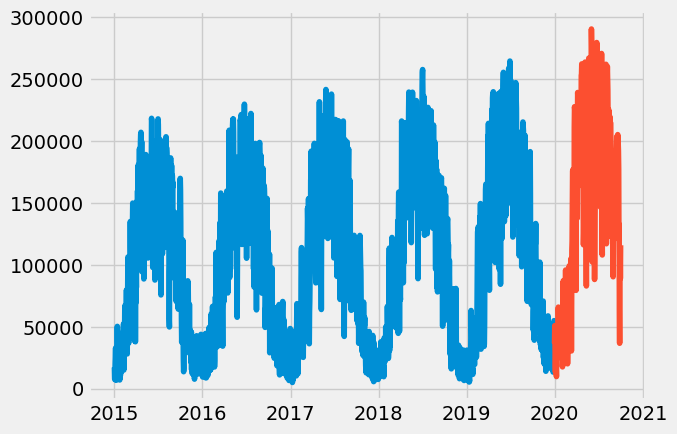

In [35]:

plt.plot(solar_train_df['DE_solar_generation_actual'])
plt.plot(solar_test_df['DE_solar_generation_actual'])
plt.show()

In [36]:
# weekly:

solar_weekly_ts = ger_weekly_generation_df[['DE_solar_generation_actual']]
weekly_period = 52 # 52 days in year

1

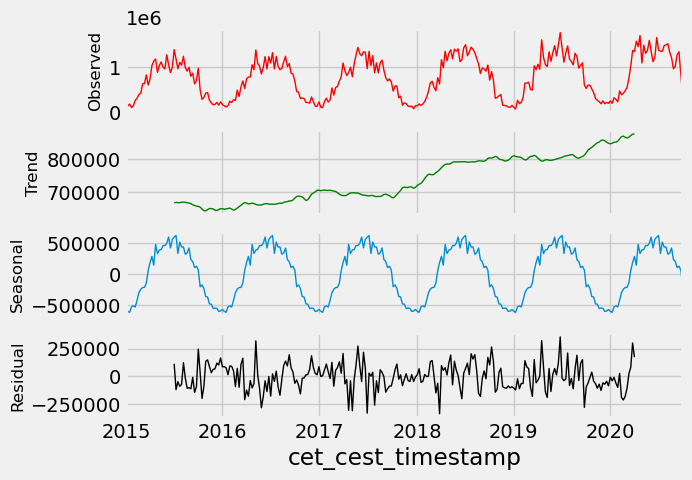

In [37]:
plot_seasonal_components(solar_weekly_ts, weekly_period) # ['solar_generation_actual']

In [38]:
#From the plots we can see that our data is not stationary, hence we need to perform differencing. 

<a id="identification_ts0"></a>

## 3.1. Identification

In [39]:
# d

obtain_adf_kpss_results(solar_weekly_ts, 3)

C:\Users\aksha\AppData\Local\Temp\ipykernel_23404\3261328465.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts, regression='c', nlags="auto")
C:\Users\aksha\AppData\Local\Temp\ipykernel_23404\3261328465.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts, regression='c', nlags="auto")
C:\Users\aksha\AppData\Local\Temp\ipykernel_23404\3261328465.py:21: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(ts, regression='c', nlags="auto")


,d,adf_stats,p-value,is_adf_stationary,is_kpss_stationary,is_stationary
0,0,5.226015e-10,0.1,True,True,True
1,1,3.690592e-04,0.1,True,True,True
2,2,1.592642e-17,0.1,True,True,True


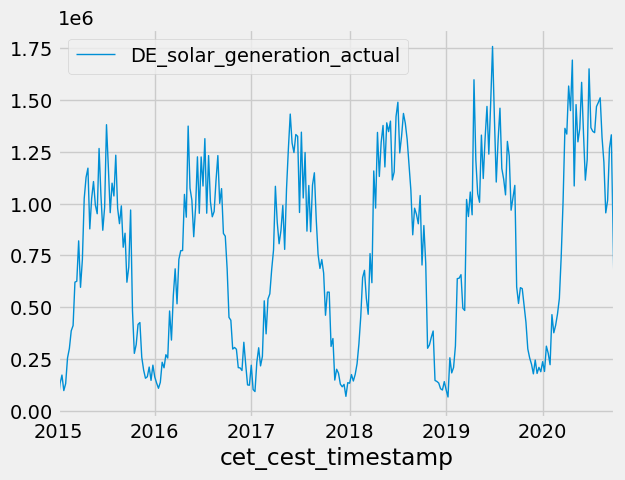

ADF Statistic: -7.0609353366640555
p-value: 5.226014857499817e-10
Critical values: {'1%': -3.453342167806272, '5%': -2.871663828287282, '10%': -2.572164381381345}


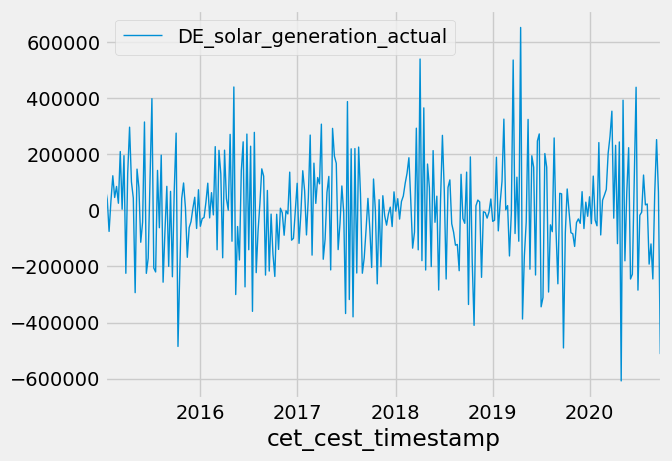

ADF Statistic: -4.346246414814749
p-value: 0.0003690591947709213
Critical values: {'1%': -3.452867117291862, '5%': -2.8714554160827745, '10%': -2.5720532321867466}


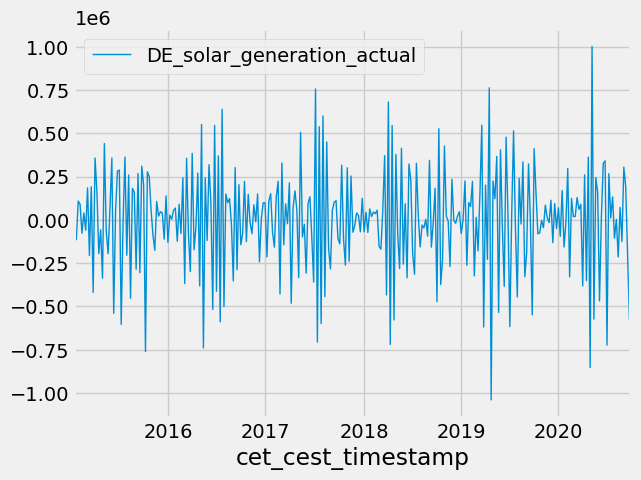

ADF Statistic: -10.03018128304594
p-value: 1.5926415682008518e-17
Critical values: {'1%': -3.453102162983312, '5%': -2.871558538275452, '10%': -2.5721082282996433}


1

In [40]:
# For time series
run_adf_test(solar_weekly_ts, 0)

# For the first difference of the time series
run_adf_test(solar_weekly_ts, 1)

# For the second difference of the time series
run_adf_test(solar_weekly_ts, 2)

In [41]:
#Results of stationary tests we can see that differencing only once is enough hence d = 1.

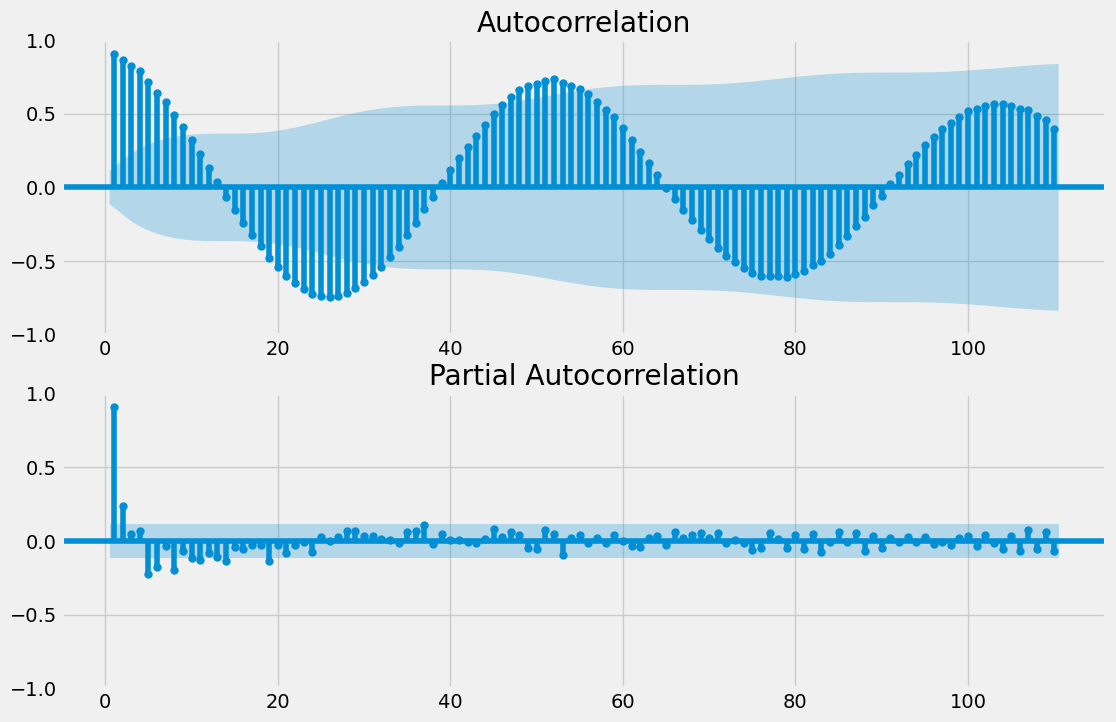

1

In [42]:
plot_acf_pacf(solar_weekly_ts, 110)

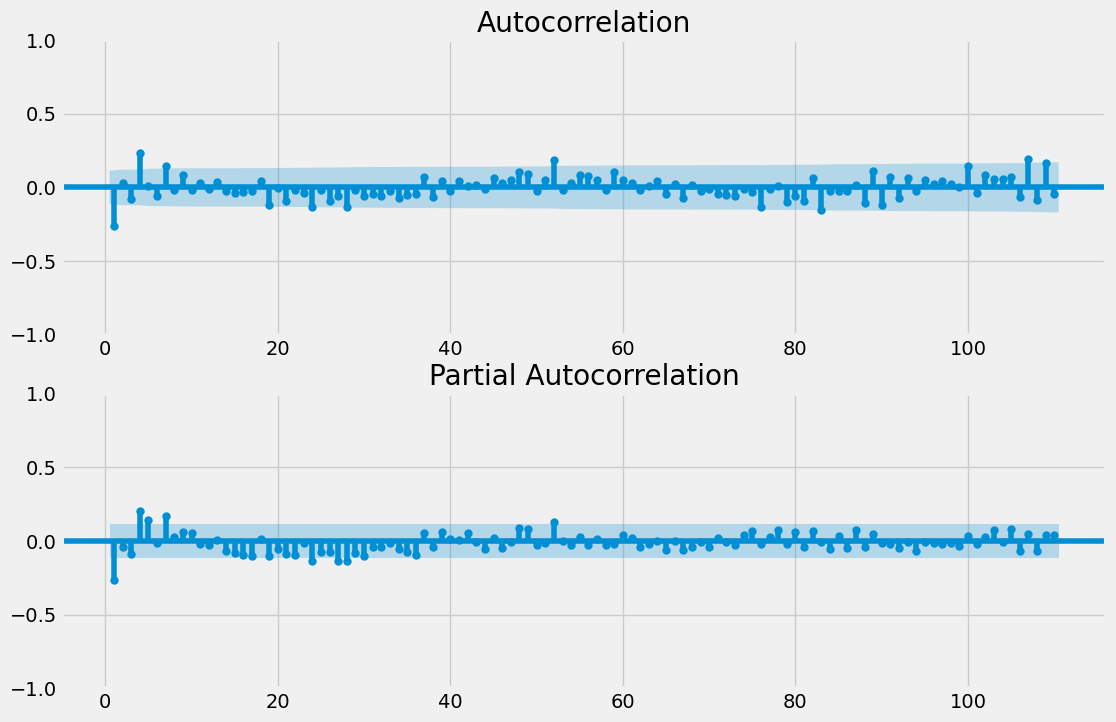

1

In [43]:
plot_acf_pacf(solar_weekly_ts.diff().dropna(), 110)

<a id="estimation_ts0"></a>

## 3.2. Estimation

In [44]:
# p, q

sort_aic_bic(solar_weekly_ts, 1, 11, 11)

c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.

Sorting by AIC:
     p   q          AIC          BIC
0    7   7  8043.011187  8098.567925
1    5   7  8049.510515  8097.659688
2    6   7  8050.198937  8102.051891
3    7  10  8050.309873  8116.977958
4    8   7  8050.952580  8110.213099
5    5   8  8053.233271  8105.086225
6    4   7  8055.861853  8100.307243
7    6   8  8056.287590  8111.844327
8    6   6  8056.716370  8104.865542
9    5   6  8056.737567  8101.182957
10  10   4  8057.538964  8113.095701
11   7   9  8058.056479  8121.020781
12   7   6  8058.965391  8110.818346
13  10   5  8059.395518  8118.656038
14   9   7  8060.689092  8123.653394
15   6   9  8062.761634  8122.022153
16   5  10  8063.867490  8123.128009
17   8   8  8064.191941  8127.156243
18   2   3  8064.234265  8086.456960
19   7   4  8065.838603  8110.283993
20   8   9  8066.075489  8132.743573
21  10   6  8066.083698  8129.048000
22   7   8  8066.612983  8125.873503
23   9   2  8067.244131  8111.689520
24   9  10  8068.370267  8142.445917
25   8   5  8068.91647

c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1

<a id="diagnostics_ts0"></a>

## 3.3. Model diagnostics

c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error from residuals: 120842.82797464775

                                   SARIMAX Results                                    
Dep. Variable:     DE_solar_generation_actual   No. Observations:                  301
Model:                         ARIMA(9, 1, 5)   Log Likelihood               -4021.220
Date:                        Thu, 04 Jul 2024   AIC                           8072.439
Time:                                05:13:43   BIC                           8127.996
Sample:                            01-04-2015   HQIC                          8094.673
                                 - 10-04-2020                                         
Covariance Type:                          opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4866      0.343     -1.420      0.156      -1.158       0.185
ar.L2      

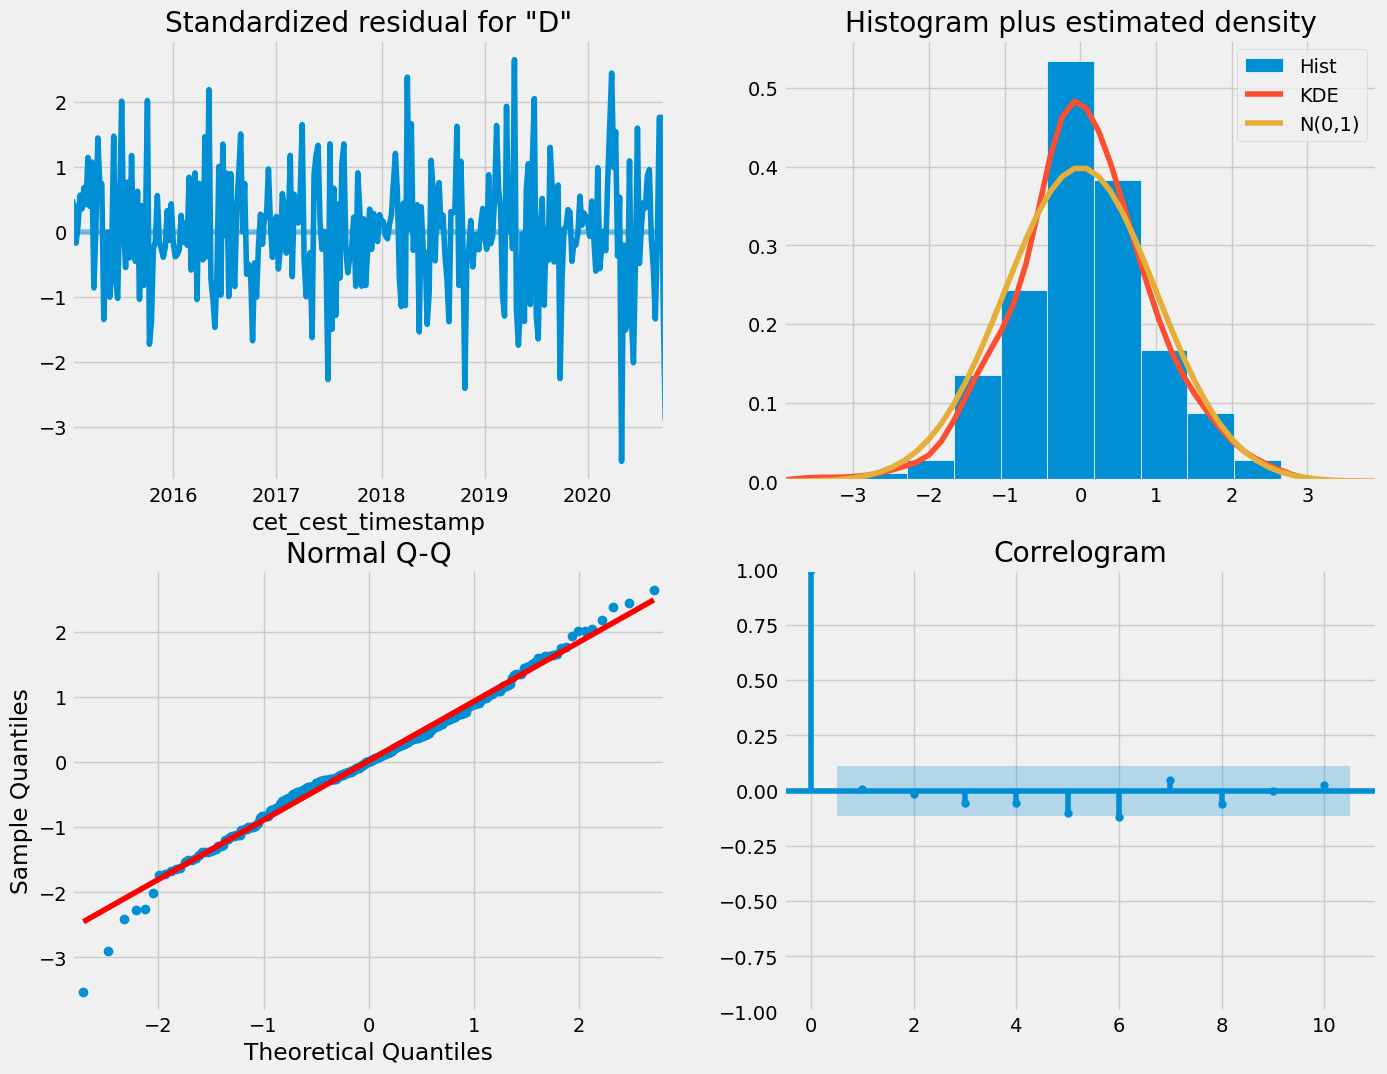

In [45]:
solar_weekly_ts_results = arima_diagnostics(solar_weekly_ts, 9,1,5)

In [46]:
#TO DO - after output check
#Prob(Q) = 0.84 > 0.05. We shouldn’t reject the null hypothesis that the residuals are uncorrelated so **the residuals are not correlated**. 

#Prob(JB) = 0.02 < 0.05. We reject the null hypothesis that the residuals are normally distributed. Therefore, **the residuals are not normally distributed**.
#After analyzing of plots:

#Therefore, all in all the model pointed by our empirical search seems to be a good model.

<a id="seasonal_ts0"></a>

## 3.4. Seasonal Differencing

In [47]:
# D
#D is already observed to be 1

In [48]:
# P, Q
# To Do - Check and make weekly dataset 
ger_daily_df = pd.read_csv('all_ger_daily_generation.csv', sep='\t')
ger_daily_df['cet_cest_timestamp'] = pd.to_datetime(ger_daily_df['cet_cest_timestamp'], utc=True)
ger_daily_df.set_index('cet_cest_timestamp', inplace=True)
ger_daily_df.sort_index(inplace=True)
ger_weekly_generation_df = ger_daily_df.resample('W').sum()
ger_weekly_generation_df.head()


,DE_load_actual_entsoe_transparency,DE_solar_capacity,DE_solar_generation_actual,trend,seasonal,residual,is_outlier
cet_cest_timestamp,,,,,,,
2015-01-04 00:00:00+00:00,4534439.0,3613204.0,52074.0,0.0,-415864.278260,0.0,0
2015-01-11 00:00:00+00:00,9440105.0,6259187.0,132229.0,0.0,-618135.040524,0.0,0
2015-01-18 00:00:00+00:00,9689010.0,6261185.0,172051.0,0.0,-585660.554496,0.0,0
2015-01-25 00:00:00+00:00,9847035.0,6265837.0,97130.0,0.0,-528766.075044,0.0,0
2015-02-01 00:00:00+00:00,9867317.0,6272902.0,130888.0,0.0,-518675.816962,0.0,0


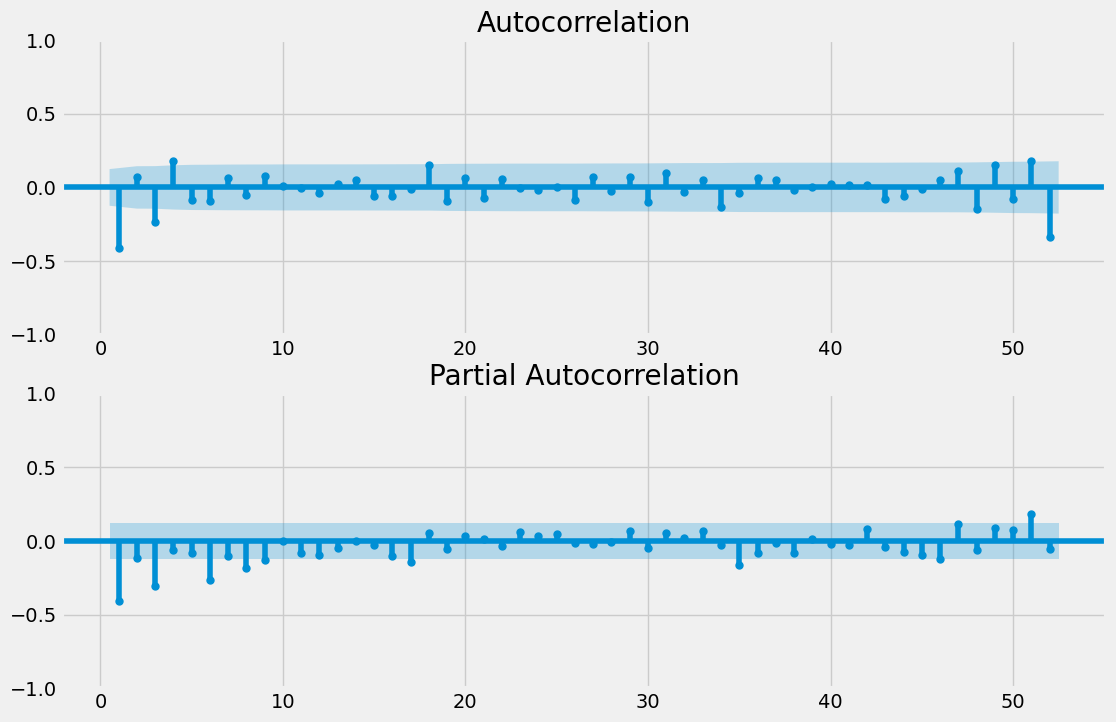

1

In [49]:
plot_acf_pacf(solar_weekly_ts.diff().diff(weekly_period).dropna(), 52)

In [50]:
#To Do - update after output
#The Seasonal ACF and PACF plots look like an ARMA(1,1) model, i.e., **P = 1** and **Q = 1**. 


c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error from residuals: 132042.28576044465

                                     SARIMAX Results                                      
Dep. Variable:         DE_solar_generation_actual   No. Observations:                  301
Model:             ARIMA(4, 1, 7)x(1, 1, [1], 52)   Log Likelihood               -3329.676
Date:                            Thu, 04 Jul 2024   AIC                           6687.351
Time:                                    05:16:48   BIC                           6736.539
Sample:                                01-04-2015   HQIC                          6707.152
                                     - 10-04-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3043      0.178     -1.709      0.087    

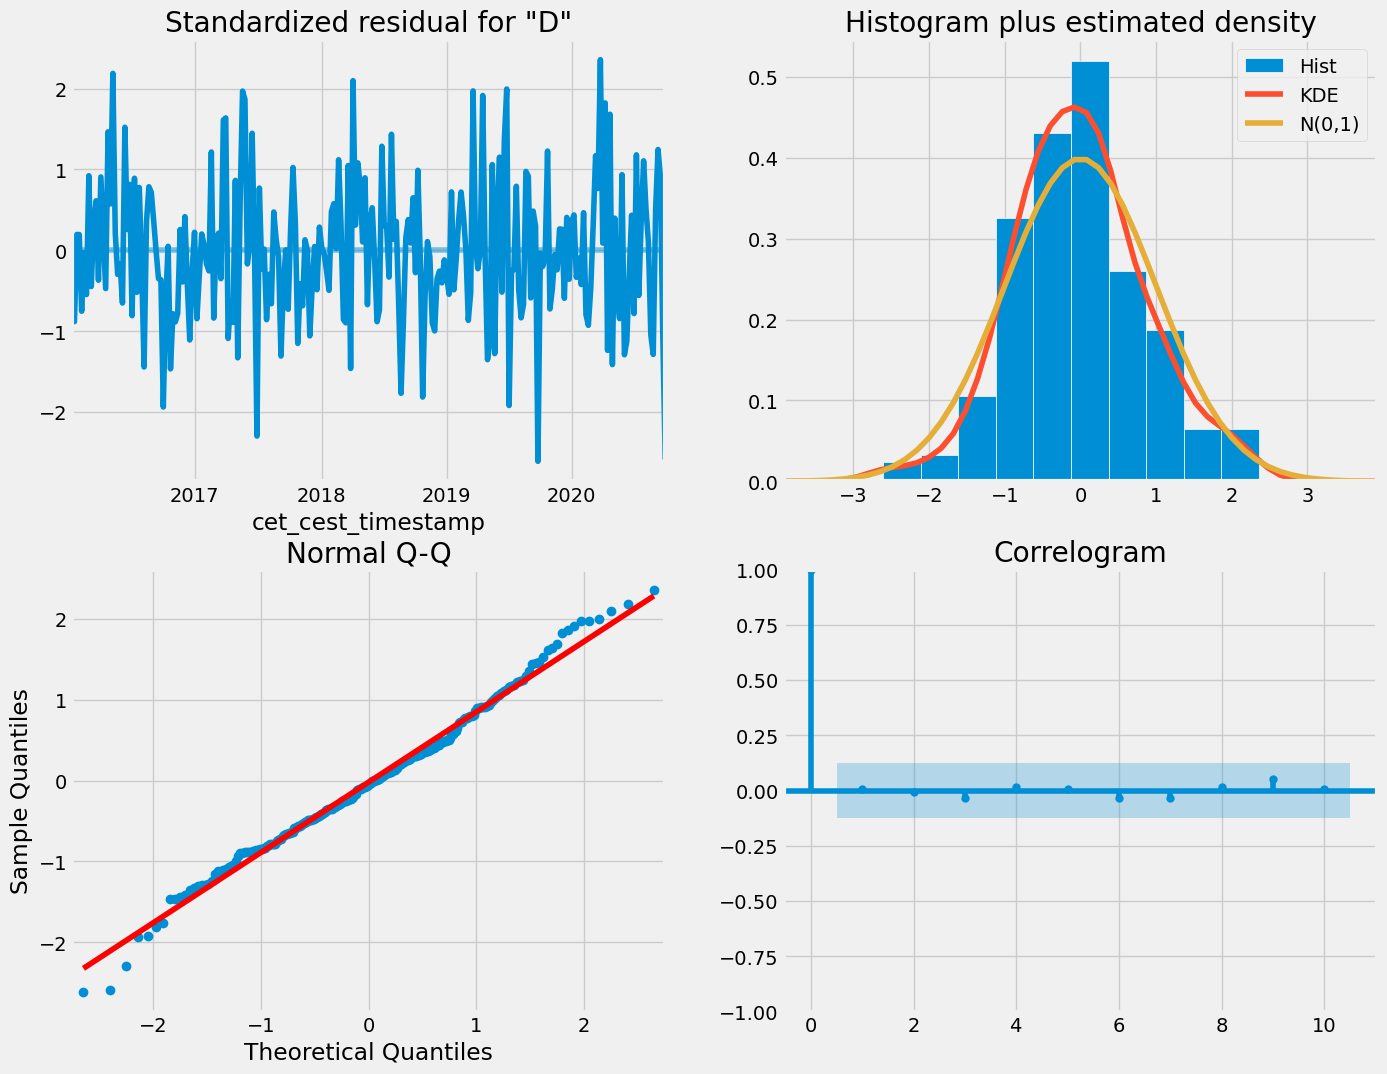

In [51]:
#To do - update based on output
solar_weekly_ts_seasonal_results = sarima_diagnostics(solar_weekly_ts, 4,1,7,1,1,1,52) # 2,1,2,1,1,1  # 6,1,1,0,1,1,52

<a id="forecasting_ts0"></a>

## 3.5. Forecasting

In [52]:
filled_2020_length = (datetime(2020, 10, 1, 0, 0, 0, 0) - datetime(2020, 1, 1, 0, 0, 0, 0)).days
print(filled_2020_length)

rest_2020_length = (datetime(2020, 12, 31, 0, 0, 0, 0) - datetime(2020, 10, 1, 0, 0, 0, 0)).days
print(rest_2020_length)

274
91


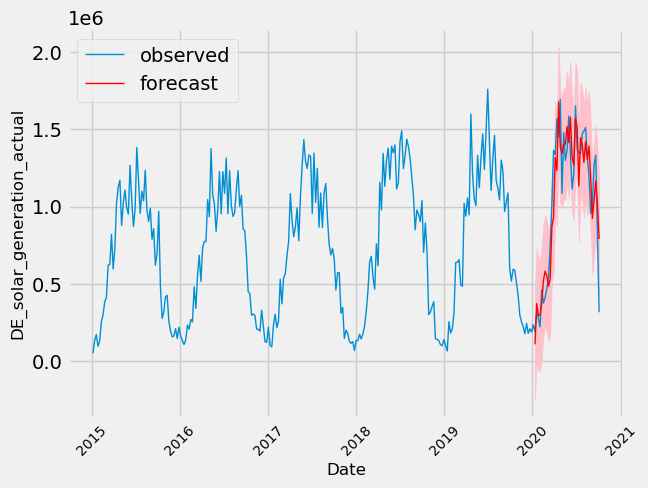

In [53]:
# for non-dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_weekly_ts_seasonal_results, 'DE_solar_generation_actual', filled_2020_length//7, False
)
arima_plot(solar_weekly_ts, mean_predict, lower_limits, upper_limits)


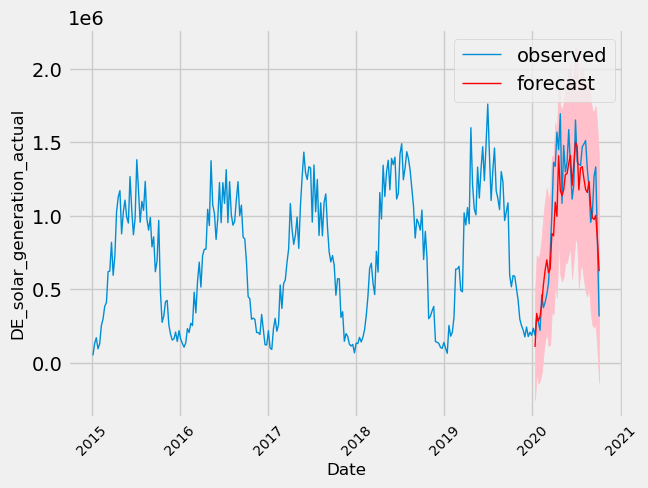

In [54]:
# for dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_weekly_ts_seasonal_results, 'DE_solar_generation_actual', filled_2020_length//7, True
)
arima_plot(solar_weekly_ts, mean_predict, lower_limits, upper_limits)


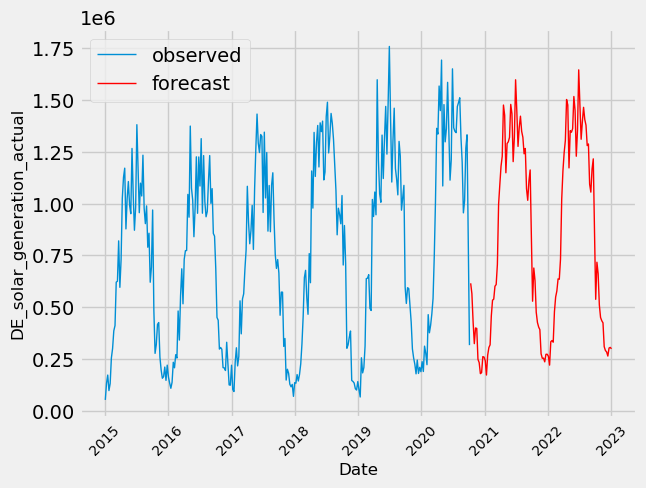

1

In [55]:
solar_weekly_ts_forecast = arima_forecast(solar_weekly_ts_seasonal_results, (rest_2020_length+365*2)//7)
arima_plot_future(solar_weekly_ts, solar_weekly_ts_forecast)

<a id="accuracy_ts0"></a>

## 3.6. Model accuracy 

In [56]:
#We can calculate **mean absolute percentage error (MAPE) between original and predicted datasets for 2020. 

In [57]:
arima_mae_relative(solar_weekly_ts, solar_weekly_ts_seasonal_results, filled_2020_length, True)   # dynamic = true

0.19129320432591743

In [58]:
arima_mae_relative(solar_weekly_ts, solar_weekly_ts_seasonal_results, filled_2020_length, False)   #dynamic = False

0.19971391445384726

In [59]:
## Finding Best P, D, Q for ARIMA Model with parameters 915

all_params_df_9_1_5 = list_params_for_mape(solar_weekly_ts, [9], [1], [5], range(0, 3), range(0, 2), range(0, 3), 52, filled_2020_length, False)

In [60]:
#To DO : Best parameters are: (9, 1, 5, 2, 1, 2) 

c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error from residuals: 130490.94232186506

                                       SARIMAX Results                                       
Dep. Variable:            DE_solar_generation_actual   No. Observations:                  301
Model:             ARIMA(9, 1, 5)x(2, 1, [1, 2], 52)   Log Likelihood               -3328.771
Date:                               Thu, 04 Jul 2024   AIC                           6695.543
Time:                                       05:21:15   BIC                           6762.298
Sample:                                   01-04-2015   HQIC                          6722.416
                                        - 10-04-2020                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2274      1.498  

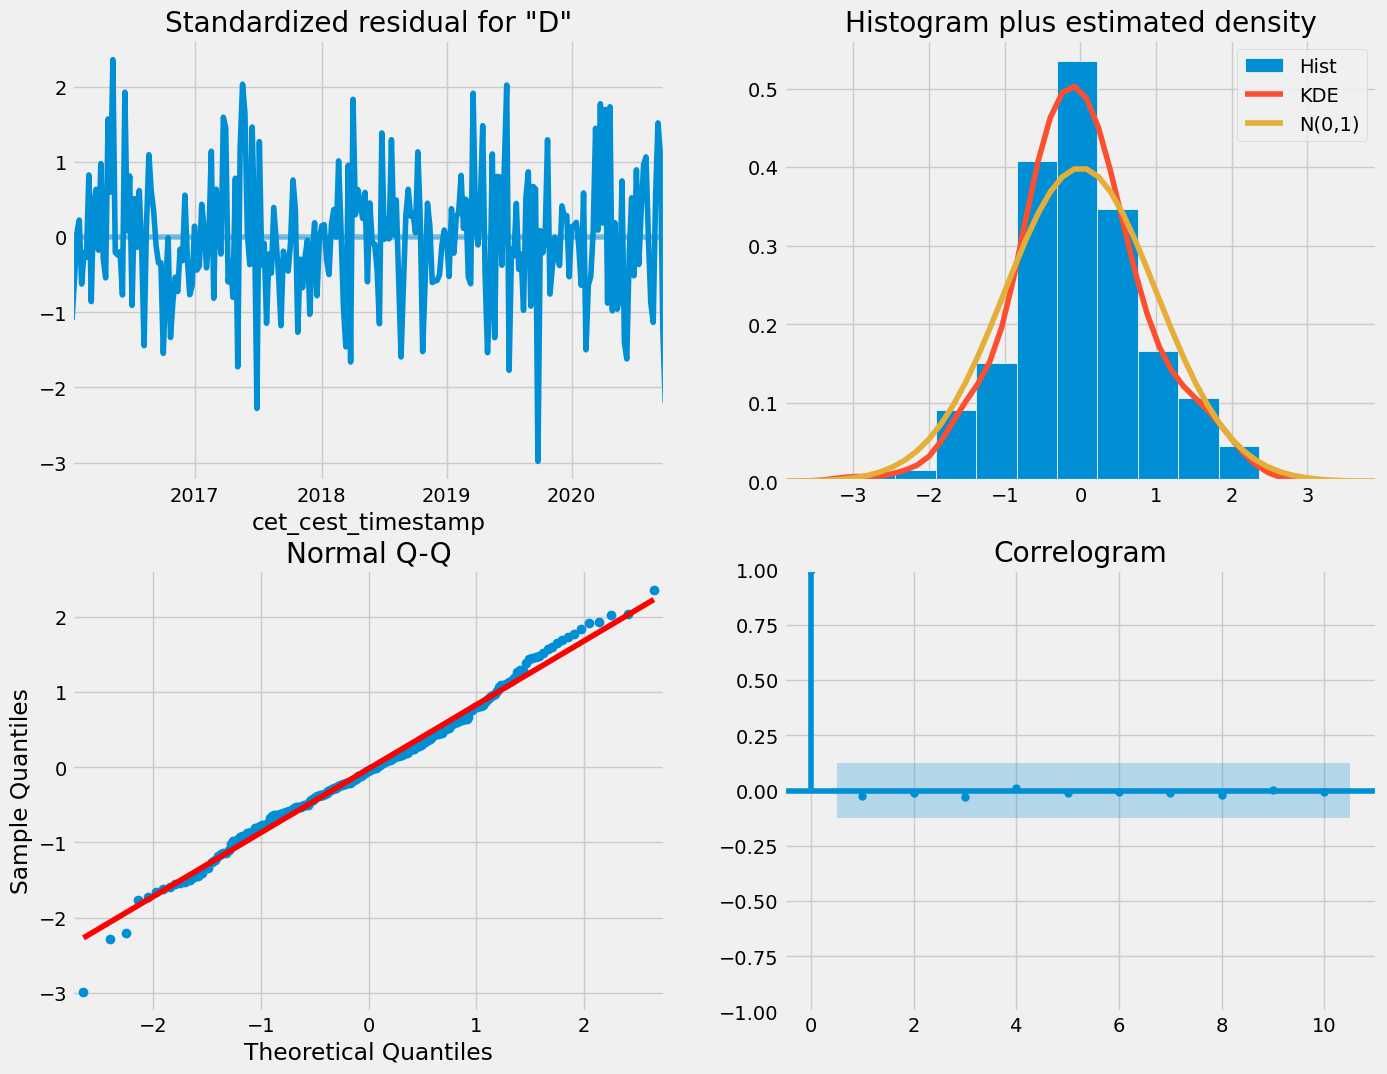

0.19302952676353735

In [61]:
## ARIMA MAPE

arima_mae_relative(solar_weekly_ts, sarima_diagnostics(solar_weekly_ts, 9, 1, 5, 2, 1, 2, 52), filled_2020_length, True)

c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\aksha\.conda\envs\vgtut\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean absolute error from residuals: 130490.94232186506

                                       SARIMAX Results                                       
Dep. Variable:            DE_solar_generation_actual   No. Observations:                  301
Model:             ARIMA(9, 1, 5)x(2, 1, [1, 2], 52)   Log Likelihood               -3328.771
Date:                               Thu, 04 Jul 2024   AIC                           6695.543
Time:                                       05:25:46   BIC                           6762.298
Sample:                                   01-04-2015   HQIC                          6722.416
                                        - 10-04-2020                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2274      1.498  

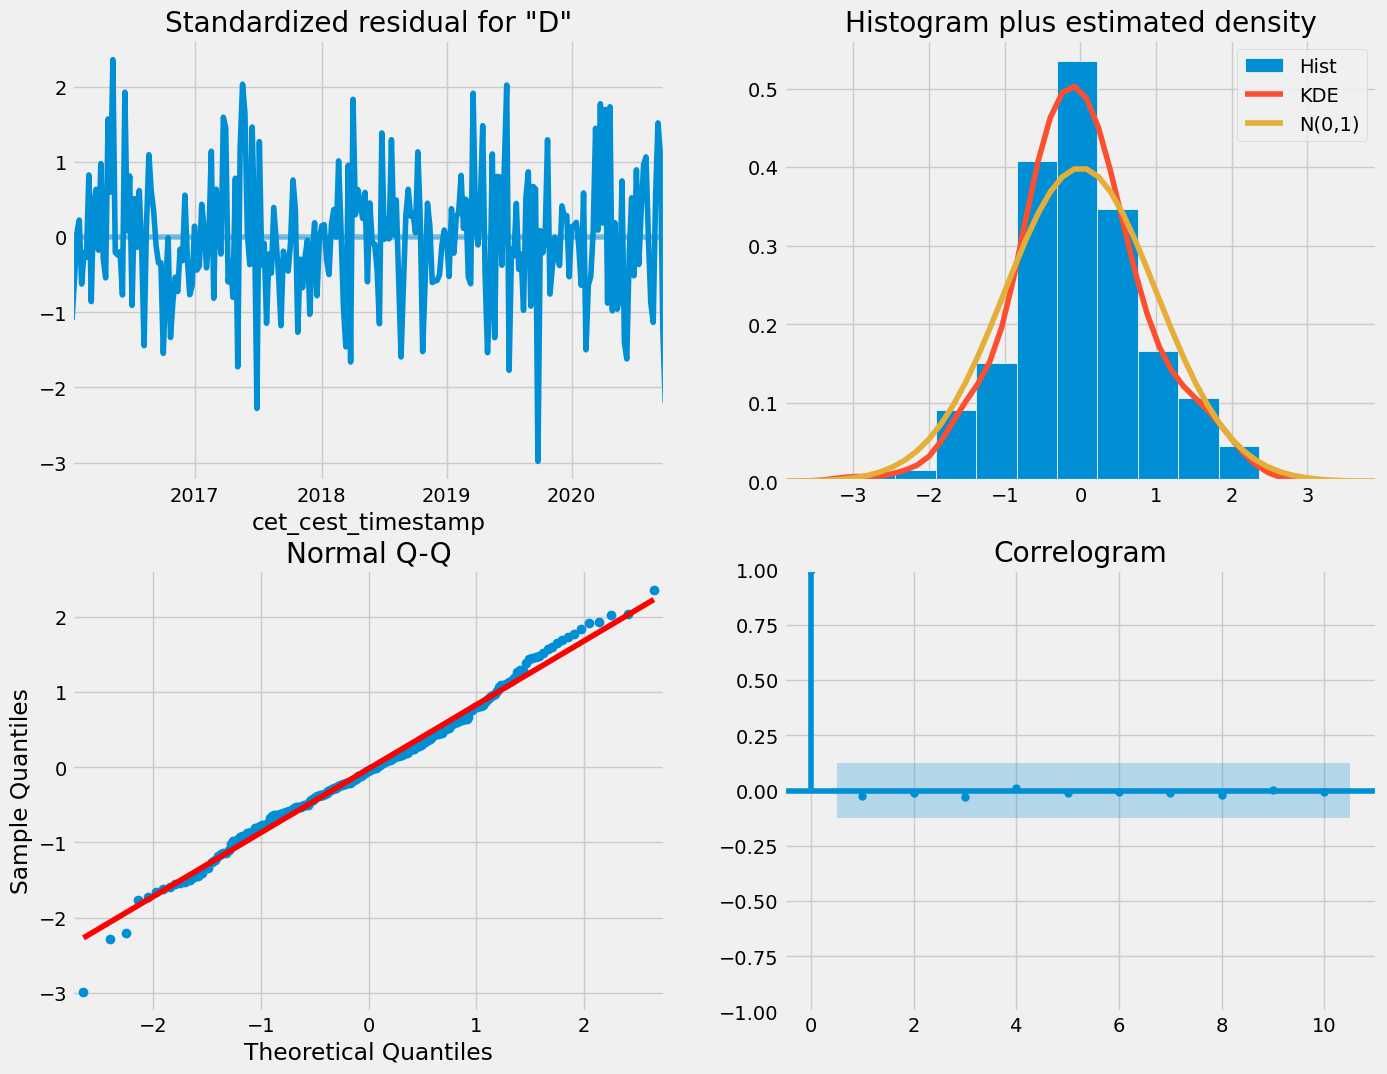

In [62]:
solar_weekly_ts_seasonal_results_915212 = sarima_diagnostics(solar_weekly_ts, 9, 1, 5, 2, 1, 2, 52)


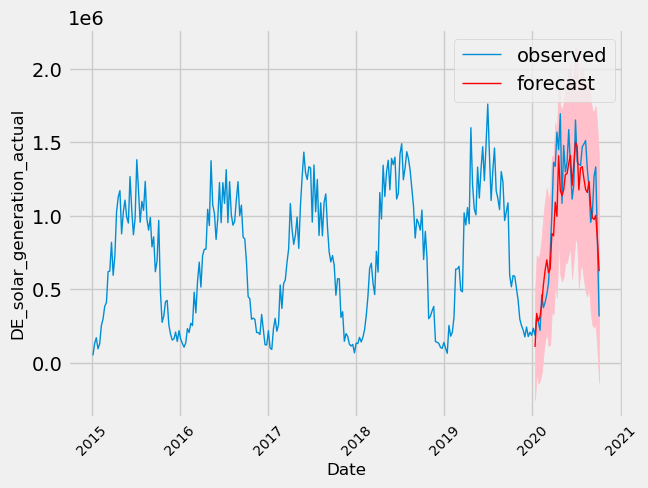

In [84]:
# for dynamic

mean_predict, lower_limits, upper_limits = arima_limits(
    solar_weekly_ts_seasonal_results, 'DE_solar_generation_actual', filled_2020_length//7, True
)
arima_plot(solar_weekly_ts, mean_predict, lower_limits, upper_limits)

time = solar_weekly_ts.index
observed = solar_weekly_ts['DE_solar_generation_actual']
combined_df = pd.DataFrame({
    'Time': time,
    'Observed': observed,
    'Forecast': mean_predict,
    'Lower Limit': lower_limits,
    'Upper Limit': upper_limits
})

combined_df.to_csv('forecasted_values_with_observed.csv', index=False)

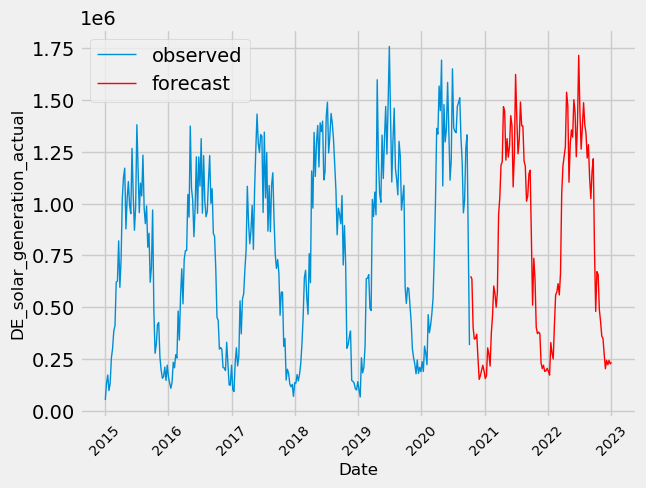

1

In [95]:
arima_plot_future(solar_weekly_ts, arima_forecast(solar_weekly_ts_seasonal_results_915212, (rest_2020_length+365*2)//7))


<a id="accuracy_ts0"></a>

## 3.7. Model validation 

In [65]:
# =================== MODEL VALIDATION ======================
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

print(slices)

[[ 17098   7757   7237 ...  32623  27269  20226]
 [ 20211  24680  20268 ...  36616  49518  27900]
 [ 65601 101146  70464 ... 110024  71204  42625]
 ...
 [134785 137382 137123 ...  55422  81450  84290]
 [ 42740  41930  23394 ...  33068  31003  63537]
 [ 18571  17306  19737 ...  24022  29477  44928]]


In [66]:
# Define ranges for SARIMA parameters
p_values = [4, 7, 9]
d_values = [1]  # since d=1
q_values = [5, 6, 7]
P_values = [0, 1, 2]
D_values = [1]
Q_values = [0, 1, 2]
S = 52  # Assuming weekly seasonality
# Perform validation
best_params, best_mape, all_results = grid_search_sarima(slices, p_values, d_values, q_values, P_values, D_values, Q_values, S)

print(f"Best parameters: {best_params}")
print(f"Best MAPE: {best_mape}")

Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(0,1,0,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(0,1,1,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(0,1,2,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(1,1,0,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(1,1,1,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(1,1,2,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(2,1,0,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5), (P,D,Q,S)=(2,1,1,52): y should be a 1d array, got an array of shape (49, 365) instead.
Error with model (p,d,q)=(4,1,5)

In [67]:
# Fit the SARIMA model on the entire dataset using the best parameters
#To DO- update best parameters after output
best_p, best_d, best_q, best_P, best_D, best_Q, best_S = (9, 1, 5, 1, 0, 1, 52)
# best_p, best_d, best_q, best_P, best_D, best_Q, best_S = best_params

data = pd.read_csv('all_ger_daily_generation.csv', sep='\t')

model = SARIMAX(data, order=(best_p, best_d, best_q), seasonal_order=(best_P, best_D, best_Q, best_S))
model_fit = model.fit(disp=False)

# Forecast the next 7 days
forecast_steps = 7
forecast = model_fit.get_forecast(steps=forecast_steps)

# Extract the predicted mean and confidence intervals
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# Print the forecasted values
print("Forecasted Values:")
print(forecast_mean)

print("\nConfidence Intervals:")
print(forecast_ci)


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:

# Plot the historical data and forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Observed', linewidth=2)
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps + 1, closed='right')
plt.plot(forecast_index, forecast_mean, label='Forecast', color='r', linewidth=2)
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.xlabel('Date')
plt.ylabel('DE Solar Generation Actual')
plt.title('7-Day Forecast for DE Solar Generation')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#To do : Compare forecast with capacity and load

# ===================== THE END ========================    